# Simulate Thompson Subsampling

Thompson sampling approach requires updating posteriors for each iteration, however, in each iteration we only know one new label and that may be supply much information for updating. So instead of updating all posteriors we uniformly random sample some entities and relations to update. 

We experiments on how subsampling affects the ROC_AUC_SCORE, cumulative gain as well as running time.

Evaluation metrics:

(1)ROC_AUC_SCORE: calculated between true labels and predictions for each iterations  
(2)Cumulative gain: for each iteration, if the maximum prediction corresponding with the valid labels gain 1, otherwise 0. Show cumulative gain for all iterations.
(3)running time: average running time for each iteration

We chose repeated labelling and Thompson Sampling for 5,000 iterations, and used [NATIONS](https://github.com/dongwookim-ml/kg-data) dataset as an example, there are totally 2,024 valid triples. 

Experiment 1: sampling all

Experiment 2: subsampling 50% relations and entities

Experiment 3: subsampling 25% relations and entities


In [1]:
# direct to parent folder
import sys
sys.path.append("..")

from acton.database import LabelOnlyASCIIReader, LabelOnlyManagedHDF5Database
from acton.predictors import TensorPredictor
from acton.recommenders import ThompsonSamplingRecommender
from acton.labellers import LabelOnlyDatabaseLabeller
import acton.acton
import tempfile
import astropy.io.ascii as io_ascii
import os.path
import numpy
import logging
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logging.basicConfig(level = logging.DEBUG)

_path = '../tests/kg-data/nation/triples.txt'
output_path = '../acton/acton.proto'
n_dim = 10
TS= 0.0
RANDOM = 1.0

In [ ]:
with LabelOnlyASCIIReader(_path, n_dim) as reader:
    n_relations = reader.n_relations
    n_entities = reader.n_entities
    totoal_size = n_relations * n_entities * n_entities
    ids = numpy.arange(totoal_size)
    
    N_EPOCHS = 5000
    repeated_labelling = True

    results = defaultdict(list)
    
    # rtrs: repeated train ROC-AUC-SCORE
    # rtes: repeated test ROC-AUC-SCORE
    # rg: repeated cumulative gain
    
    # subsampling all
    results['TS_rtrs100'], results['TS_rtes100'], results['TS_rg100'], results['time100'] =  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='LabelOnlyDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            sub_percent = 1.0
    )
    
    with open('outfile_all', 'wb') as fp:
        pickle.dump(results,fp)

    # subsampling 50%
    
    results['TS_rtrs50'], results['TS_rtes50'], results['TS_rg50'], results['time50'] =  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='LabelOnlyDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            sub_percent = 0.5
    )
    
    with open('outfile_sub50', 'wb') as fp:
        pickle.dump(results,fp)
        
    # subsampling 25%
    results['TS_rtrs25'], results['TS_rtes25'], results['TS_rg25'], results['time25'] =  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='LabelOnlyDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            sub_percent = 0.25
    )
    
    with open('outfile_sub25', 'wb') as fp:
        pickle.dump(results,fp)
        
    # subsampling 10%
    results['TS_rtrs10'], results['TS_rtes10'], results['TS_rg10'], results['time10'] =  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='LabelOnlyDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            sub_percent = 0.1
    )
    
    with open('outfile_sub10', 'wb') as fp:
        pickle.dump(results,fp)

In [2]:
with open ('outfile_all', 'rb') as fp:
    results_all = pickle.load(fp)
    
with open ('outfile_sub50', 'rb') as fp:
    results_50 = pickle.load(fp)
    
with open ('outfile_sub25', 'rb') as fp:
    results_25 = pickle.load(fp)
    
with open ('outfile_sub10', 'rb') as fp:
    results_10 = pickle.load(fp)

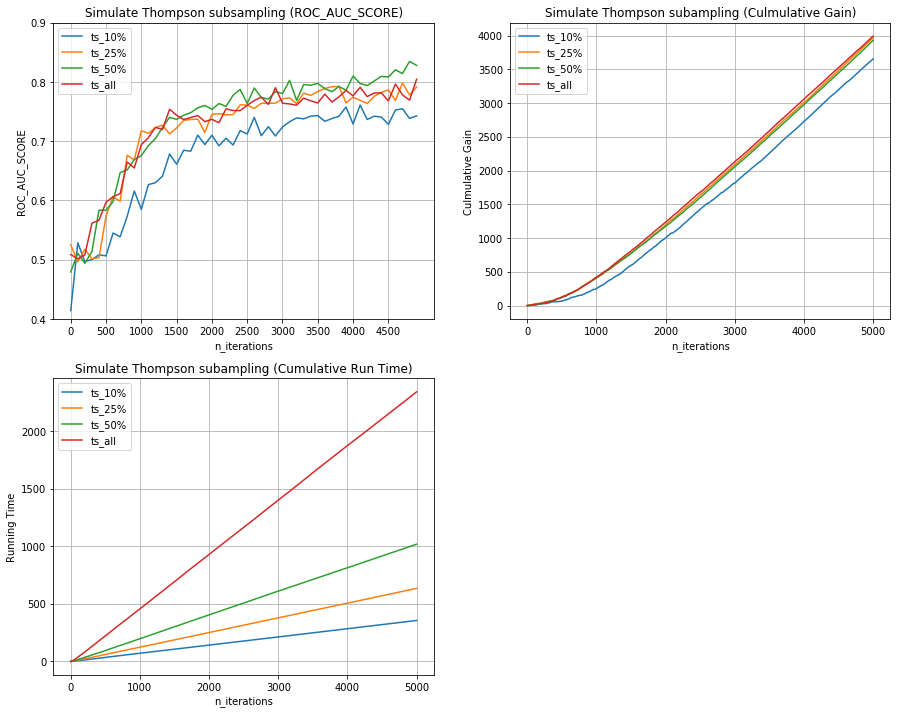

In [15]:
# with open ('outfile_sub50', 'rb') as fp:
#    results = pickle.load(fp)

plt.figure(figsize= (15,12))


# only plot 2000 iterations for the purpose of comparison with unrepeated labelling
plt.subplot(221)
plt.plot(results_10['TS_rtrs10'][::100], label = 'ts_10%')
plt.plot(results_25['TS_rtrs25'][::100], label = 'ts_25%')
plt.plot(results_50['TS_rtrs50'][::100], label = 'ts_50%')
plt.plot(results_all['TS_rtrs100'][::100], label = 'ts_all')
plt.xticks(numpy.arange(50, step = 5), numpy.arange(5000)[::500])
plt.xlabel('n_iterations')
plt.ylabel('ROC_AUC_SCORE')
plt.ylim(0.4,0.9)
plt.title('Simulate Thompson subsampling (ROC_AUC_SCORE)')
plt.grid(True)
plt.legend()

plt.subplot(222)
plt.plot(numpy.cumsum(results_10['TS_rg10']), label = 'ts_10%')
plt.plot(numpy.cumsum(results_25['TS_rg25']), label = 'ts_25%')
plt.plot(numpy.cumsum(results_50['TS_rg50']), label = 'ts_50%')
plt.plot(numpy.cumsum(results_all['TS_rg100']), label = 'ts_all')
plt.ylabel('Culmulative Gain')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (Culmulative Gain)')
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.plot(numpy.cumsum(results_10['time10']), label = 'ts_10%')
plt.plot(numpy.cumsum(results_25['time25']), label = 'ts_25%')
plt.plot(numpy.cumsum(results_50['time50']), label = 'ts_50%')
plt.plot(numpy.cumsum(results_all['time100']), label = 'ts_all')
plt.ylabel('Running Time')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (Cumulative Run Time)')
plt.grid(True)
plt.legend()


From the above plots, we can see except 10% subsampling (e.g. sampling 1 entities, 6 relations in each iteration), other samplings achieve similar cumulative gain (but still all > 50% > 25%). 

The 50% subsampling achieves best ROC_AUC_SCORE, with only less than a half of the running time of sampling all entities and relations.

Thus, subsampling does help save time but achieves similar or even slightly better accuracy. Although subsampling does not update all posteriors once it gets the new label, one particular entity or relation can be updated in every few iterations. For example, if we subsampling 50% of entities, then one certain entity can be chosen every two iterations on average (in probability). This kind of updating frequency allows the sampling not to miss much valued information and to save time at the same time.

### plot gain vs running time

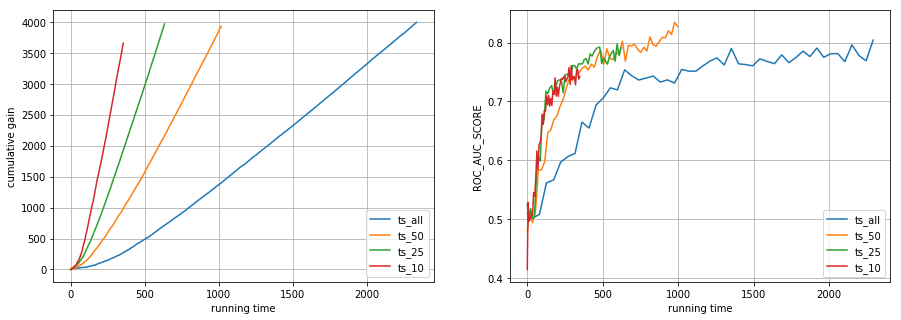

In [18]:
plt.figure(figsize= (15,5))

plt.subplot(121)
plt.plot(numpy.cumsum(results_all['time100']), 
         numpy.cumsum(results_all['TS_rg100']), label="ts_all")
plt.plot(numpy.cumsum(results_50['time50']), 
         numpy.cumsum(results_50['TS_rg50']), label="ts_50")
plt.plot(numpy.cumsum(results_25['time25']), 
         numpy.cumsum(results_25['TS_rg25']), label="ts_25")
plt.plot(numpy.cumsum(results_10['time10']), 
         numpy.cumsum(results_10['TS_rg10']), label="ts_10")
plt.xlabel("running time")
plt.ylabel("cumulative gain")
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(numpy.cumsum(results_all['time100'])[::100], 
         results_all['TS_rtrs100'][::100], label="ts_all")
plt.plot(numpy.cumsum(results_50['time50'])[::100], 
         results_50['TS_rtrs50'][::100], label="ts_50")
plt.plot(numpy.cumsum(results_25['time25'])[::100], 
         results_25['TS_rtrs25'][::100], label="ts_25")
plt.plot(numpy.cumsum(results_10['time10'])[::100], 
         results_10['TS_rtrs10'][::100], label="ts_10")
plt.xlabel("running time")
plt.ylabel("ROC_AUC_SCORE")
plt.legend()
plt.grid(True)
